In [ ]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.8 MB/s eta 0:00:00


In [ ]:
def extract_district_name_number_and_county(file_name):
  district_name = file_name[0:len(file_name) - 12]
  district_number = file_name[-6:]
  county = ''
  print(district_name, district_number)

  if(district_name == 'FORT_BEND_ISD'):
    county = 'Fort Bend County'
  elif(district_name == 'CLEAR_CREEK_ISD'):
    county = 'Galveston County'
  else:
    county = 'Harris County'

  return (district_name, district_number, county)

In [ ]:
import re

In [ ]:
def extract_grade_subject(text):
  # print('extract_grade_subject ', text)
  map_subject_to_grade_level = {
      'End of Course EnglishI': '9',
      'End of Course AlgebraI': '9',
      'End of Course Biology': '9',
      'End of Course EnglishII': '10',
      'End of Course U.S.History': '11',
  }
  text = text.replace(" ", "").strip()

  # handle grade pattern such as grade 3 science
  match = re.match(r"Grade\s*(\d+)([A-Za-z/&]+)", text.replace(" ", ""))
  if match:
    grade = match.group(1)
    subject = match.group(2)
    return grade, subject

  # handle end of course... and sat/act....
  if text.startswith('End'):
    subject = text.removeprefix('EndofCourse')
    subject = 'End of Course ' + subject
    return  map_subject_to_grade_level[subject], subject

  if text.startswith('SAT'):
    return '12', 'SAT/ACT All Subjects'

  print(f'unrecognize header {text}')

In [ ]:
def match_performance_category(text):
  performance_categories = [
      "At Approaches Grade Level or Above",
      "At Meets Grade Level or Above",
      "At Masters Grade Level"
  ]
  text = text.replace("\n", " ").strip()

  for category in performance_categories:
    if text.startswith(category):
      return category

  return None

In [ ]:
def extract_rows_from_table(tables, district_name, district_number, county):
  column_names = ['performance_category','school_year', 'state', 'region_04', 'district', 'African American',
                'Hispanic', 'White', 'American Indian', 'Asian', 'Pacific Islander',
                'Two or more races', 'Special Ed (current)', 'Special Ed (former)', 'continuously enrolled',
                'non-continuously enrolled', 'Econ disadv', 'EB/EL (Current & Monitored)']
  rows = []
  grade_level = None
  subject = None

  for table in tables:
    for row_index, row in enumerate(table):

      if not row or not isinstance(row[0], str):
        continue

      if row[0].startswith('Texas') or (len(row) > 1 and row[1] == 'School\nYear') or row[0].startswith('STAAR'):
        continue

      elif row[0].startswith(('Grade','End','SAT')):
        grade_level, subject = extract_grade_subject(row[0])
        continue



      elif row[0].startswith('At'):
        # loop over the row to create a student_group and new row for each student group
        performance_category = match_performance_category(row[0])
        if performance_category is None:
          continue

        if grade_level is None or subject is None:
          print(f"Skipping row because grade_level or subject is None. row {row}")
          continue

        # process 2024 row
        for index in range(5, len(row)):
          student_group = column_names[index]
          value = row[index]
          value = None if value in (None, '*', '-') else value

          rows.append({
              "district_name": district_name,
              "district_number": district_number,
              "county": county,
              "state": "Texas",
              "region": "Region 4",
              "grade_level": grade_level,
              "subject": subject,
              "performance_category": performance_category,
              "school_year": row[1],
              "student_group": student_group,
              "value": value
          })

        if row_index + 1 < len(table):
          next_row = table[row_index + 1]
          if next_row[0] is None and next_row[1] == '2023':
            for index in range(5, len(next_row)):
              value = next_row[index]
              value = None if value in (None, '*', '-') else value
              rows.append({
                  "district_name": district_name,
                  "district_number": district_number,
                  "county": county,
                  "state": "Texas",
                  "region": "Region 4",
                  "grade_level": grade_level,
                  "subject": subject,
                  "performance_category": performance_category,
                  "school_year": next_row[1],
                  "student_group": column_names[index],
                  "value": value
              })
        else:
          continue


  return rows

In [ ]:
from pathlib import Path
files_pdf = Path("./").glob("*.pdf")

In [ ]:
import pdfplumber

all_rows = []
for file_path in files_pdf:
  district_name, district_number, county = extract_district_name_number_and_county(file_path.stem)

  with pdfplumber.open(file_path) as pdf:
    for page_num in range(2, 7):
      page = pdf.pages[page_num]
      tables = page.extract_tables()

      if not tables:
        print(f"No tables found on page {page_num + 1}")
        continue

      rows = extract_rows_from_table(tables, district_name, district_number, county)
      all_rows.extend(rows)

SPRING_BRANCH_ISD 101919
Skipping row because grade_level or subject is None. row ['At Approaches Grade Level or\nAbove', '2024', '79%', '79%', '69%', '63%', '72%', '81%', '69%', '98%', '56%', '59%', '35%', '64%', '72%', '66%', '68%', '71%']
Skipping row because grade_level or subject is None. row ['At Meets Grade Level or Above', '2024', '55%', '55%', '40%', '34%', '42%', '53%', '47%', '73%', '33%', '35%', '17%', '30%', '43%', '35%', '38%', '40%']
Skipping row because grade_level or subject is None. row ['At Masters Grade Level', '2024', '29%', '30%', '15%', '12%', '16%', '21%', '13%', '51%', '22%', '9%', '4%', '4%', '17%', '13%', '14%', '15%']
Skipping row because grade_level or subject is None. row ['At Meets Grade Level or Above', '2024', '39%', '41%', '22%', '15%', '25%', '29%', '20%', '62%', '38%', '29%', '16%', '13%', '27%', '16%', '21%', '26%']
Skipping row because grade_level or subject is None. row ['At Masters Grade Level', '2024', '14%', '15%', '5%', '3%', '6%', '6%', '0%',

In [ ]:
import pandas as pd
final_df = pd.DataFrame(all_rows)
final_df

,district_name,district_number,county,state,region,grade_level,subject,performance_category,school_year,student_group,value
0,SPRING_BRANCH_ISD,101919,Harris County,Texas,Region 4,3,Reading,At Approaches Grade Level or Above,2024,African American,52%
1,SPRING_BRANCH_ISD,101919,Harris County,Texas,Region 4,3,Reading,At Approaches Grade Level or Above,2024,Hispanic,60%
2,SPRING_BRANCH_ISD,101919,Harris County,Texas,Region 4,3,Reading,At Approaches Grade Level or Above,2024,White,68%
3,SPRING_BRANCH_ISD,101919,Harris County,Texas,Region 4,3,Reading,At Approaches Grade Level or Above,2024,American Indian,57%
4,SPRING_BRANCH_ISD,101919,Harris County,Texas,Region 4,3,Reading,At Approaches Grade Level or Above,2024,Asian,94%
...,...,...,...,...,...,...,...,...,...,...,...
8575,HOUSTON_ISD,101912,Harris County,Texas,Region 4,12,SAT/ACT All Subjects,At Meets Grade Level or Above,2023,Special Ed (former),63%
8576,HOUSTON_ISD,101912,Harris County,Texas,Region 4,12,SAT/ACT All Subjects,At Meets Grade Level or Above,2023,continuously enrolled,58%
8577,HOUSTON_ISD,101912,Harris County,Texas,Region 4,12,SAT/ACT All Subjects,At Meets Grade Level or Above,2023,non-continuously enrolled,43%
8578,HOUSTON_ISD,101912,Harris County,Texas,Region 4,12,SAT/ACT All Subjects,At Meets Grade Level or Above,2023,Econ disadv,44%


In [ ]:
print(final_df.isnull().sum())
print(final_df.dtypes)
print(final_df['value'].unique())

district_name             0
district_number           0
county                    0
state                     0
region                    0
grade_level               0
subject                   0
performance_category      0
school_year               0
student_group             0
value                   331
dtype: int64
district_name           object
district_number         object
county                  object
state                   object
region                  object
grade_level             object
subject                 object
performance_category    object
school_year             object
student_group           object
value                   object
dtype: object
['52%' '60%' '68%' '57%' '94%' '67%' '66%' '32%' '54%' '59%' '56%' '58%'
 '64%' '78%' '50%' '75%' '83%' None '39%' '62%' '61%' '25%' '30%' '48%'
 '43%' '69%' '33%' '37%' '19%' '22%' '28%' '27%' '34%' '44%' '47%' '23%'
 '24%' '31%' '5%' '7%' '16%' '14%' '17%' '15%' '2%' '0%' '8%' '6%' '11%'
 '10%' '3%' '9%' '72%' '71%' '84%

# drop missing values


In [ ]:
final_df = final_df.dropna(subset=['value'])

In [ ]:
final_df['value'] = final_df['value'].str.replace('%', '').astype(float)
final_df['grade_level'] = final_df['grade_level'].astype(int)
final_df['school_year'] = final_df['school_year'].astype(int)

/tmp/ipython-input-14-3196740820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['value'] = final_df['value'].str.replace('%', '').astype(float)
/tmp/ipython-input-14-3196740820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['grade_level'] = final_df['grade_level'].astype(int)
/tmp/ipython-input-14-3196740820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [ ]:
print(final_df.isnull().sum())
print(final_df.dtypes)
print(final_df['value'].unique())


district_name           0
district_number         0
county                  0
state                   0
region                  0
grade_level             0
subject                 0
performance_category    0
school_year             0
student_group           0
value                   0
dtype: int64
district_name            object
district_number          object
county                   object
state                    object
region                   object
grade_level               int64
subject                  object
performance_category     object
school_year               int64
student_group            object
value                   float64
dtype: object
[ 52.  60.  68.  57.  94.  67.  66.  32.  54.  59.  56.  58.  64.  78.
  50.  75.  83.  39.  62.  61.  25.  30.  48.  43.  69.  33.  37.  19.
  22.  28.  27.  34.  44.  47.  23.  24.  31.   5.   7.  16.  14.  17.
  15.   2.   0.   8.   6.  11.  10.   3.   9.  72.  71.  84.  79.  80.
  65.  20.  41.  21.  29.  26.  36.  42.   4.  12. 

In [ ]:
final_df['district_number'].unique()

array(['101919', '101903', '079907', '101907', '084910', '101912'],
      dtype=object)

In [ ]:
final_df.to_csv('cleaned_data_final.csv', index=False)

<Axes: >

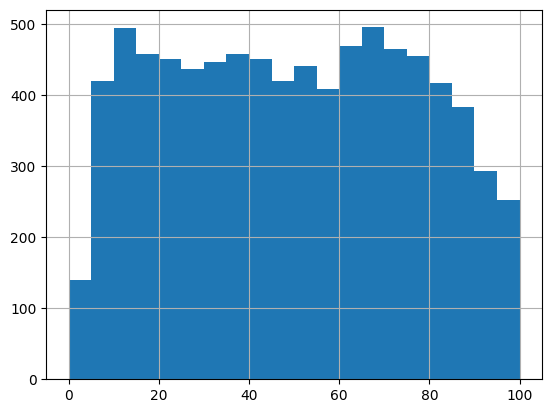

In [ ]:
final_df.describe(include='all')
final_df['value'].describe()
final_df['value'].hist(bins=20)